In [1]:
import numpy as np #
import struct # read file. 
#import gzip  # used to read gz file. But I prefer using struct. 
from skimage.transform import rescale # rescale image 
import matplotlib.pyplot as plt # 
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

You can download the .gz files on: 

http://yann.lecun.com/exdb/mnist/

And unzip the files, and you can read them like shown below. 

You can also use keras for MNIST dataset. 

(10000, 28, 28)
(64, 64)


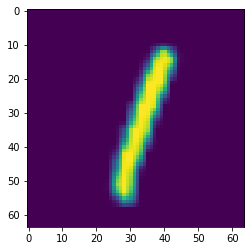

In [2]:
# read locally, for example. 
imgfile  = 't10k-images.idx3-ubyte'

with open(imgfile,'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))

print(data.shape)

# Show one of the rescaled images. (28,28) -> (64,64)
image = np.asarray(data[5]).squeeze()
image = rescale(image,2.3)
print(image.shape)
plt.imshow(image) 
plt.show()
del data

# Numpy/np is used commonly when you deal with data science in python language, 
# you can use numpy array data structure to save arrays using 
# np.save(filename, variable)
# You can load them using 
# ny.load(filename)

In [3]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
# Creating tags with VAE
import torch
import torch.nn as nn                          # Class that implements a model (such as a Neural Network)
import torch.nn.functional as functional       # import torch.nn.functional as F

# MNIST dataset can be well predicted with other methods. You don't need a very complex neural network. 
# But we are using pytorch, so let's do it with neural network. 

In [5]:
# set up a structure to read all files. 
# Set up the NN
# Set to GPU if available for NN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set up Transformations (0-1 Scaling only)
#t = transforms.Compose([transforms.ToTensor()])

print('Graphics card device', torch.cuda.get_device_name(0))
print('Allocated', torch.cuda.memory_allocated())
print('Cached', torch.cuda.memory_cached())


"""
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) #sample-wise divide


class Reshape(nn.Module):
    def __init__(self, shape = (1, 64, 64)):
        super(Reshape, self).__init__()
        self.shape = shape
    
    def forward(self, input):
        return input.view(input.size(0), self.shape[0], self.shape[1], self.shape[2])
"""

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        """
        self.encoder = nn.Sequential(
            # half padding #batch size, channel, height, width
            # b 64 64 1  -> b 64 64 32
            nn.Conv2d(1, 32, kernel_size=(11,11), stride=(1,1), padding = (5,5)),
            nn.ReLU(),
            # b 64 64 32 -> b 32 32 32 
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            # b 32 32 32 -> b 32 32 32
            nn.Conv2d(32, 64, kernel_size=(5,5), stride=(1,1), padding = (2,2)),
            nn.ReLU(),
            # b 32 32 64 -> b 16 16 64 
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            # b 16 16 64 -> b 16 16 128
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding = (1,1)),
            nn.ReLU(),
            # b 16 16 128 -> 8 8 128 
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            # 8 8 128 -> b 8*8*128 = 8192
            Flatten()
        )


        # b 8192 -> b 50 50
        self.fc1 = nn.Linear(8192, 50)
        self.fc2 = nn.Linear(8192, 50)
        self.fc3 = nn.Linear(50, 1024)
        
                # Notice that it is not symmetric: it is not necessary to be. 
        self.decoder = nn.Sequential(
            nn.ReLU(),
            # b 1024 -> b 16 8 8
            Reshape(shape = (16, 8, 8)), 
            # b 16 8 8 -> b 128 16 16
            nn.ConvTranspose2d(16, 128, kernel_size = (3,3), stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            # b 128 16 16 -> b 64 32 32
            nn.ConvTranspose2d(128, 64, kernel_size = (5,5), stride = 2, padding = 2, output_padding = 1),
            nn.ReLU(),
            # b 64 32 32 -> b 32 64 64
            nn.ConvTranspose2d(64, 32, kernel_size = (11,11), stride = 2, padding = 5, output_padding = 1),
            nn.ReLU(),
            # b 32 64 64 -> b 1 64 64 
            nn.ConvTranspose2d(32, 1, kernel_size = (3,3), stride = 1, padding = 1, output_padding = 0),
            nn.Sigmoid(),
        )
    
    
        """
        

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(128, 20)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
        )

    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar) #std = logvar.mul(0.5).exp_() 
        eps = torch.randn_like(mu)
        z = mu + std * eps
        return z


    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]


    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar


    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                print('Not in model from file', name) 
                continue #I rarely use this. 
            param = param.data
            print(name+ ' is loaded. ')
            own_state[name].copy_(param)
        for name, param in own_state.items():
            if name not in state_dict:
                print('Not in model from model', name)
        return own_state


# Loss
def vae_loss(image, reconstruction, mu, logvar):
    """Loss for the Variational AutoEncoder."""
    # Binary Cross Entropy for batch
    BCE = functional.binary_cross_entropy(input=reconstruction.view(-1, 28*28), target = image.view(-1, 28*28),reduction='sum')
    # Closed-form KL Divergencet
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def complete_loss(image, reconstruction, mu, logvar):
    return vae_loss(image, reconstruction, mu, logvar)


torch.manual_seed(20) # randomly picked. 
vae_torch = VAE()
if torch.cuda.is_available():
    vae_torch.cuda()


cuda:0
Graphics card device NVIDIA GeForce RTX 3070
Allocated 0


C:\ProgramData\Anaconda3\envs\dms\lib\site-packages\torch\cuda\memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


Cached 0


  0%|          | 0/20 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dms\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\envs\dms\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https

tensor(-2.2115e+08, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▌         | 1/20 [00:04<01:21,  4.26s/it]

tensor(-2.2157e+08, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 2/20 [00:06<01:08,  3.80s/it]

tensor(-2.2167e+08, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 3/20 [00:09<00:59,  3.49s/it]

tensor(-2.2192e+08, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 4/20 [00:12<00:52,  3.27s/it]

tensor(-2.2203e+08, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 5/20 [00:15<00:46,  3.12s/it]

tensor(-2.2219e+08, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 6/20 [00:17<00:41,  3.00s/it]

tensor(-2.2228e+08, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 7/20 [00:20<00:37,  2.92s/it]

tensor(-2.2232e+08, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 8/20 [00:23<00:34,  2.86s/it]

tensor(-2.2237e+08, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 9/20 [00:26<00:31,  2.83s/it]

tensor(-2.2222e+08, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 10/20 [00:28<00:28,  2.80s/it]

tensor(-2.2250e+08, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 11/20 [00:31<00:24,  2.77s/it]

tensor(-2.2250e+08, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 12/20 [00:34<00:22,  2.76s/it]

tensor(-2.2273e+08, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 13/20 [00:37<00:19,  2.74s/it]

tensor(-2.2283e+08, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 14/20 [00:39<00:16,  2.75s/it]

tensor(-2.2298e+08, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 15/20 [00:42<00:13,  2.76s/it]

tensor(-2.2293e+08, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 16/20 [00:45<00:10,  2.75s/it]

tensor(-2.2283e+08, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 17/20 [00:48<00:08,  2.75s/it]

tensor(-2.2296e+08, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 18/20 [00:50<00:05,  2.74s/it]

tensor(-2.2304e+08, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 19/20 [00:53<00:02,  2.73s/it]

tensor(-2.2320e+08, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


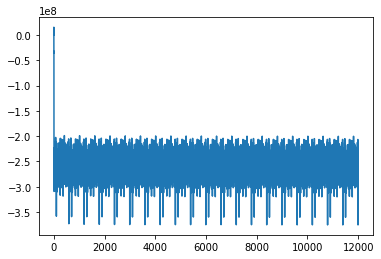

In [6]:
from tqdm import tqdm

losses = []
epoches = 20
batchsize=100
optimizer = torch.optim.Adam(vae_torch.parameters(), lr=1e-3)
save_everyEpoch = 5
ctr = 0

PATHsave = 'example.pth'
#vae_torch.load_my_state_dict(torch.load(PATHsave))# load the saved/trained parameters for neural network.

# vae_torch(torch.rand(30, 28*28).cuda()) # use this to test whether your network is correctly constructed. 
images = train_X.reshape(-1, 28*28)     # recast this into arrays. I can do this because this is a dataset that can be easily predicted. 
labels = train_y.reshape(-1, 1)         # labels

for epoch in tqdm(range(epoches)):
    ctr = ctr + 1
    num_div = images.shape[0]//batchsize 
    idx_div = np.linspace(start = 0, stop = images.shape[0], num = num_div + 1, dtype = np.int)
    for idx in range(num_div): 
        batch_X = torch.from_numpy(np.array(images[idx_div[idx]: idx_div[idx+1], :], dtype = np.float)).float()
        #batch_y = np.array(labels[idx_div[idx]: idx_div[idx+1], :], dtype = np.float)
        batch_X = batch_X.to(device)
        #batch_y = torch.from_numpy(batch_y).float().to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae_torch(batch_X)
        loss = vae_loss(batch_X, reconstruction, mu, logvar)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        losses.append(loss.clone().cpu().detach())
        pass
    if ctr == save_everyEpoch:
        #print(losses)
        torch.save(vae_torch.state_dict(), PATHsave)
        ctr = 0
    
    print(loss)



plt.plot(list(range(len(losses))), losses)
        

C:\ProgramData\Anaconda3\envs\dms\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\envs\dms\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/d

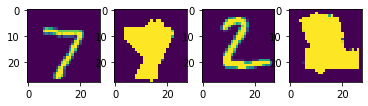

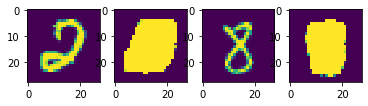

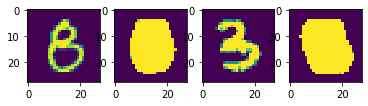

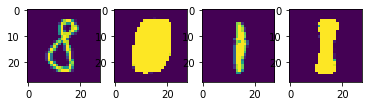

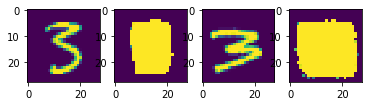

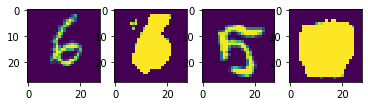

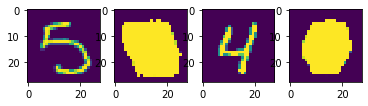

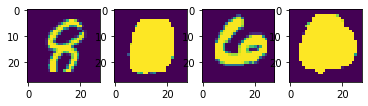

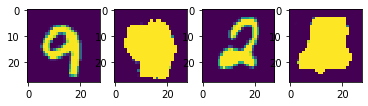

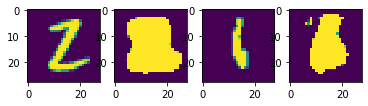

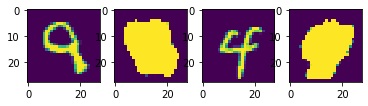

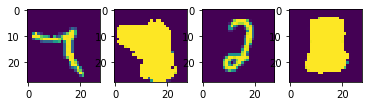

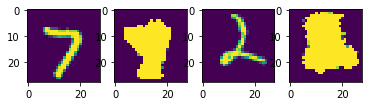

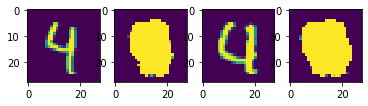

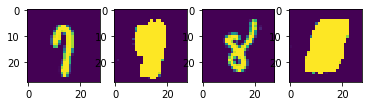

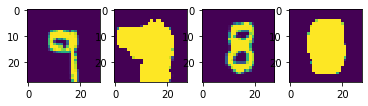

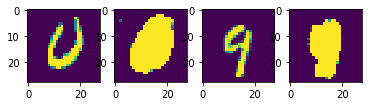

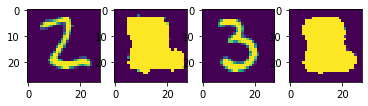

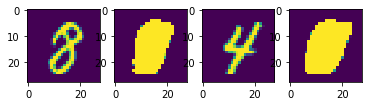

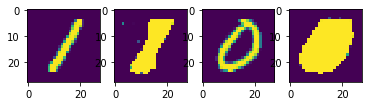

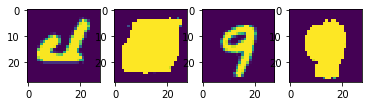

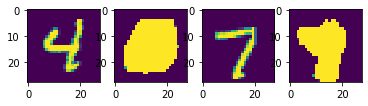

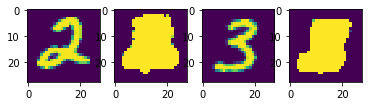

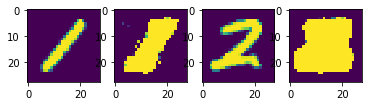

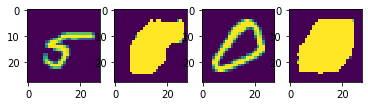

In [7]:
images = test_X.reshape(-1, 28*28)     # recast this into arrays. I can do this because this is a dataset that can be easily predicted. 
labels = test_y.reshape(-1, 1)         # labels

losses = []
batchsize=400
ctr = 0

reconstructions = []
with torch.no_grad():
    ctr = ctr + 1
    num_div = images.shape[0]//batchsize 
    idx_div = np.linspace(start = 0, stop = images.shape[0], num = num_div + 1, dtype = np.int)
    for idx in range(num_div): 
        batch_X = np.array(images[idx_div[idx]: idx_div[idx+1], :], dtype = np.float)
        batch_X = torch.from_numpy(batch_X).float().to(device)
        reconstruction, mu, logvar = vae_torch(batch_X)
        loss = complete_loss(batch_X , reconstruction, mu, logvar)
        losses.append(loss.clone().cpu().detach())
        fig, ax = plt.subplots(1,4)
        temp = reconstruction.clone().cpu().detach()
        ax[0].imshow(batch_X[0,:].cpu().reshape((28,28)))
        ax[1].imshow(temp[0,:].reshape((28,28)))
        ax[2].imshow(batch_X[1,:].cpu().reshape((28,28)))
        ax[3].imshow(temp[1,:].reshape((28,28)))
        torch.cuda.empty_cache()
        #reconstructions.append(reconstruction.clone().cpu().detach())


#reconstructions = np.concatenate(reconstructions, axis = 0)
